# OCT Image Classification

In [154]:
import pandas as pd
import numpy as np
import tensorflow as tf

## Test access to GPU

In [155]:
!nvidia-smi

Wed Nov  8 10:04:08 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   59C    P5              11W /  60W |   2661MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [156]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Become one with data

In [157]:
from Helpers_functions import *

In [158]:
from PIL import Image
image = Image.open('./OCT2017/test/CNV/CNV-1016042-1.jpeg')
data = np.asarray(image)
data

array([[ 14,   4,  44, ..., 246, 255, 255],
       [ 12,   1,  41, ..., 248, 255, 255],
       [ 22,   6,  41, ..., 251, 255, 254],
       ...,
       [255, 255, 255, ...,   3,   3,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

we don't have normalize data

In [159]:
walk_through_dir("./OCT2017/train/")

There are 4 directories and 0 images in './OCT2017/train/'.
There are 0 directories and 37205 images in './OCT2017/train/CNV'.
There are 0 directories and 11348 images in './OCT2017/train/DME'.
There are 0 directories and 26315 images in './OCT2017/train/NORMAL'.
There are 0 directories and 8616 images in './OCT2017/train/DRUSEN'.


In [160]:
walk_through_dir("./OCT2017/test/")

There are 4 directories and 0 images in './OCT2017/test/'.
There are 0 directories and 250 images in './OCT2017/test/CNV'.
There are 0 directories and 250 images in './OCT2017/test/DME'.
There are 0 directories and 250 images in './OCT2017/test/NORMAL'.
There are 0 directories and 250 images in './OCT2017/test/DRUSEN'.


probably unbalance data for `DRUSEN`

In [161]:
IMG_SIZE = (256,256)
BATCH_SIZE = 32

train_dir = "./OCT2017/train/"

test_dir = "./OCT2017/test/"

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir
                                                               ,batch_size=BATCH_SIZE
                                                               ,image_size=IMG_SIZE
                                                               ,label_mode='categorical'
                                                                ,shuffle=True)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                batch_size=BATCH_SIZE
                                                                ,image_size=IMG_SIZE
                                                                ,label_mode='categorical',
                                                                shuffle=True)

Found 83484 files belonging to 4 classes.
Found 1000 files belonging to 4 classes.


In [162]:
train_data.class_names

['CNV', 'DME', 'DRUSEN', 'NORMAL']

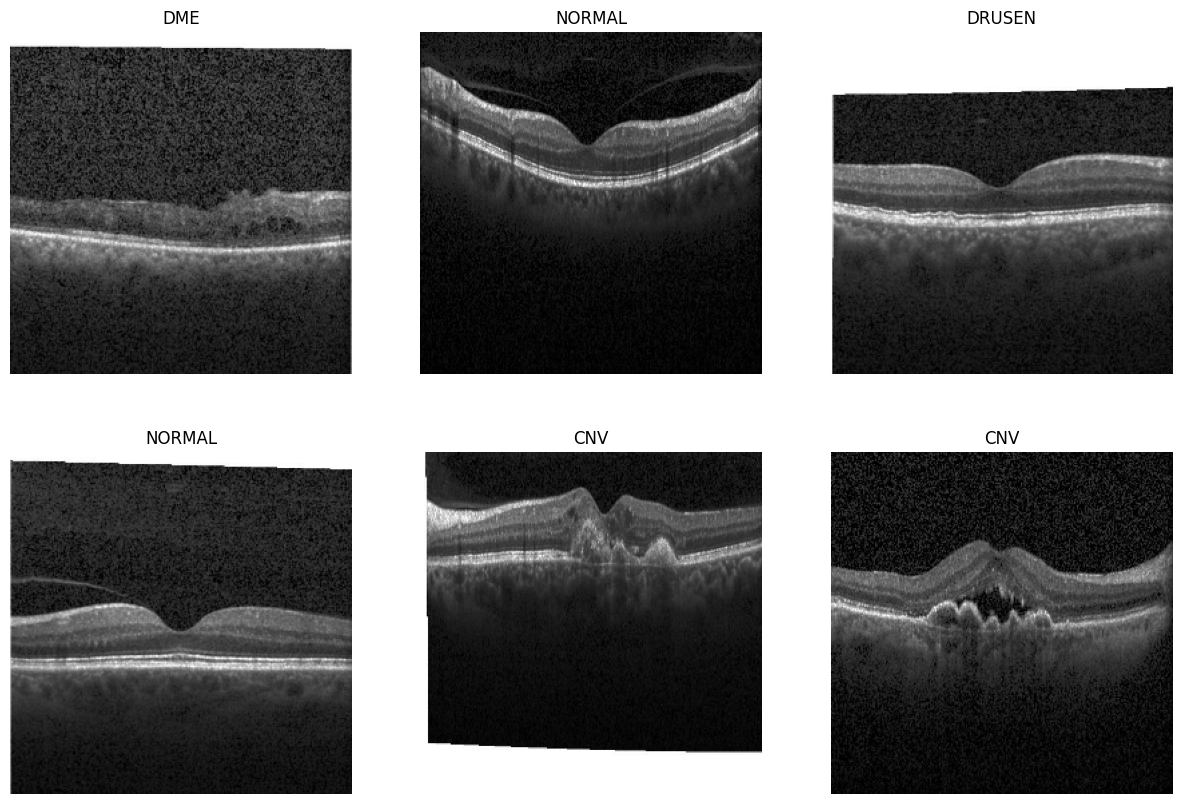

In [163]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import os
import random

plt.figure(figsize=(15,10))
i=0
for image , labels in train_data.unbatch().take(6):
    plt.subplot(2,3,i+1)
    name_class = train_data.class_names[tf.argmax(labels)]
    plt.axis('off')
    plt.title(name_class)
    plt.imshow(image/255.)
    i = i+1

In [164]:
# Define our model according to VGG architecture

Input = tf.keras.Input(shape=IMG_SIZE + (3,))
# Define convolutional layers
x = tf.keras.layers.Conv2D(10,3 , padding="valid",activation="relu")(Input)
x = tf.keras.layers.Conv2D(10,3,padding="valid",activation="relu")(x)

# Define Maxpool layers
x = tf.keras.layers.MaxPool2D(padding="valid")(x)

# Define convolutional layers
x = tf.keras.layers.Conv2D(10,3 , padding="valid",activation="relu")(x)
x = tf.keras.layers.Conv2D(10,3,padding="valid",activation="relu")(x)

x = tf.keras.layers.MaxPool2D(padding="valid")(x)
x = tf.keras.layers.Flatten()(x)


output = tf.keras.layers.Dense(4 , activation="softmax")(x)

model_1 = tf.keras.Model(Input,output)

model_1.compile(loss = tf.keras.losses.categorical_crossentropy , 
                  optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                  metrics = ["accuracy"])


In [165]:
model_1.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_56 (Conv2D)          (None, 254, 254, 10)      280       
                                                                 
 conv2d_57 (Conv2D)          (None, 252, 252, 10)      910       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 126, 126, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_58 (Conv2D)          (None, 124, 124, 10)      910       
                                                                 
 conv2d_59 (Conv2D)          (None, 122, 122, 10)      910       
                                                          

## Define some callbacks

In [166]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=2) # if val loss doesn't decreases for  2 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model
checkpoint_path = "checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=1,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)


## Fit the model

In [167]:
%%time
history = model_1.fit(train_data ,
              epochs=50,
              steps_per_epoch=len(train_data),
              callbacks=[early_stopping , model_checkpoint , reduce_lr],
              validation_data=test_data,
              validation_steps = 0.2*len(test_data))

Epoch 1/50
2608/2609 [============================>.] - ETA: 0s - loss: 0.9233 - accuracy: 0.6850INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


2609/2609 [==============================] - 124s 47ms/step - loss: 0.9233 - accuracy: 0.6851 - val_loss: 0.8887 - val_accuracy: 0.6205 - lr: 0.0010
Epoch 2/50
2608/2609 [============================>.] - ETA: 0s - loss: 0.5837 - accuracy: 0.7897INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


2609/2609 [==============================] - 125s 48ms/step - loss: 0.5836 - accuracy: 0.7897 - val_loss: 0.8284 - val_accuracy: 0.6964 - lr: 0.0010
Epoch 3/50
2608/2609 [============================>.] - ETA: 0s - loss: 0.4324 - accuracy: 0.8465INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


2609/2609 [==============================] - 127s 49ms/step - loss: 0.4324 - accuracy: 0.8465 - val_loss: 0.7043 - val_accuracy: 0.7723 - lr: 0.0010
Epoch 4/50
2608/2609 [============================>.] - ETA: 0s - loss: 0.3399 - accuracy: 0.8794
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2609/2609 [==============================] - 126s 48ms/step - loss: 0.3401 - accuracy: 0.8794 - val_loss: 0.7124 - val_accuracy: 0.7545 - lr: 0.0010
Epoch 5/50
2609/2609 [==============================] - ETA: 0s - loss: 0.1831 - accuracy: 0.9371INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


2609/2609 [==============================] - 127s 48ms/step - loss: 0.1831 - accuracy: 0.9371 - val_loss: 0.5383 - val_accuracy: 0.8571 - lr: 2.0000e-04
Epoch 6/50
2608/2609 [============================>.] - ETA: 0s - loss: 0.1442 - accuracy: 0.9514
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
2609/2609 [==============================] - 125s 48ms/step - loss: 0.1442 - accuracy: 0.9514 - val_loss: 0.7377 - val_accuracy: 0.8393 - lr: 2.0000e-04
Epoch 7/50
2609/2609 [==============================] - ETA: 0s - loss: 0.0989 - accuracy: 0.9695
Epoch 7: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
2609/2609 [==============================] - 125s 48ms/step - loss: 0.0989 - accuracy: 0.9695 - val_loss: 0.8619 - val_accuracy: 0.8036 - lr: 4.0000e-05
CPU times: user 41min 51s, sys: 2min 5s, total: 43min 56s
Wall time: 14min 39s


## Evaluate models

In [168]:
model_1.evaluate(test_data)

32/32 [==============================] - 1s 28ms/step - loss: 0.6327 - accuracy: 0.8540


[0.6326684355735779, 0.8539999723434448]

# Plot loss curves

In [152]:
loss_df = pd.DataFrame(history.history)[["loss","val_loss"]]
acc_df = pd.DataFrame(history.history)[["accuracy" , "val_accuracy"]]

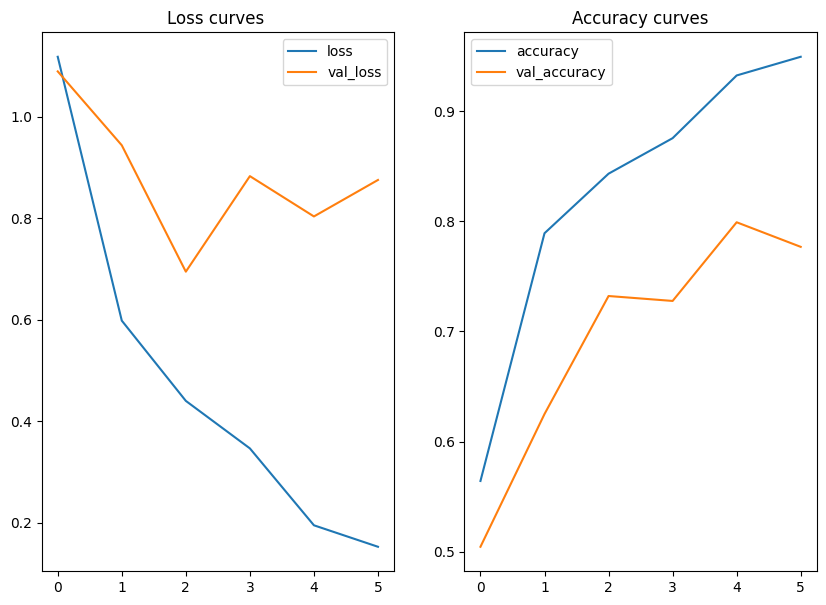

In [153]:
# plot train loss and vall loss
plt.figure(figsize = (10,7))

plt.subplot(1,2,1)
plt.plot(loss_df , label = ["loss","val_loss"])
plt.title("Loss curves ")
plt.legend()
plt.subplot(1,2,2)
plt.plot(acc_df , label = ["accuracy" , "val_accuracy"])
plt.title("Accuracy curves")

plt.legend()

## Exprimental Notes :


* We can use imageDatagen to rescale our data